In [1]:
import xpress as xp
import pandas as pd
import math
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Read the Excel file, turn into dataframe
# pool = pd.read_excel('SampleData.xlsx', engine='openpyxl')
pool = pd.read_excel('Data/Dataset25.xlsx', engine='openpyxl')

# Remove unnecessary coloumns
df = pool.drop('dage', axis=1)

In [3]:
edges = df.dropna(subset=['score']).set_index(['donor_id', 'recipient'])['score'].to_dict()

In [4]:
# Parameters for the optimization:
k = 4 # max cycle length

In [5]:
# Input data from the dataset
# Ensure compatibility with Example input data below

# This lists all donor id's that are not altruistic donors
pairs = list(set(df[df['altruistic'] != True]['donor_id']))
pairs = [float(i) for i in pairs]

 
altruistic_donors = list(set(df[df['altruistic'] == True]['donor_id']))
altruistic_donors = [float(i) for i in altruistic_donors]

nodes = pairs + altruistic_donors

edges = edges

In [76]:
# # Example input data 1

# pairs = ["P1", "P2", "P3", "P4"] 
# altruistic_donors = ["NDD1"]
# nodes = pairs + altruistic_donors
# edges = {("NDD1", "P1"): 2,
#          ("P1", "P2"): 10, 
#          ("P2", "P3"): 10,
#          ("P3", "P4"): 10,
#          ("P4", "P1"): 10
# }

# # Example input data 2

# pairs = ["P1", "P2", "P3", "P4", "P5"] 
# altruistic_donors = ["NDD1"]
# nodes = pairs + altruistic_donors
# edges = {("NDD1", "P1"): 0.1,
#          ("P1", "P2"): 10, 
#          ("P2", "P3"): 9,
#          ("P3", "P4"): 8,
#          ("P4", "P5"): 7,
#          ("P5", "P1"): 6
# }

# # Example input data 3

# pairs = ["P1", "P2", "P3", "P4", "P5"] 
# altruistic_donors = ["NDD1"]
# nodes = pairs + altruistic_donors
# edges = {("NDD1", "P1"): 0.1,
#          ("P1", "P2"): 10, 
#          ("P2", "P3"): 9,
#          ("P3", "P4"): 8,
#          ("P4", "P5"): 7
# }

In [9]:
print(len(edges))


13516


In [14]:
# Create the loop!

# Create Xpress Model
# Initialize the model
prob = xp.problem()

# Define decision variables for each edge
y = {e: xp.var(vartype=xp.binary, name=f"y_{e[0]}_{e[1]}") for e in edges}
prob.addVariable(list(y.values()))

# Objective: Maximize total benefit
prob.setObjective(xp.Sum(y[e] * w for e, w in edges.items()), sense=xp.maximize)

# Constraints
for v in pairs:
    prob.addConstraint(xp.Sum(y[e] for e in edges if e[0] == v) <= xp.Sum(y[e] for e in edges if e[1] == v))
    prob.addConstraint(xp.Sum(y[e] for e in edges if e[1] == v) <= 1)

for a in altruistic_donors:
    prob.addConstraint(xp.Sum(y[e] for e in edges if e[0] == a) <= 1)

finished = False # A flag to mark the end of the optimization.
infeasible = False # A (currently unused) flag to mark no feasible solution.
# TODO: Add a catch for no feasible solution. This shouldn't happen but it is
# probably better to be robust about this.

Gstart_time = time.time()
prob.solve()


# while finished == False and infeasible == False:
    

#     start_time = time.time()


#     # Solve the model
#     prob.controls.outputlog = 0 # This just makes it quiet to run
#     prob.solve()
#     opt_sol = prob.getSolution()
    
#     # print(f"Solver took {time.time()-start_time} seconds to run")
#     start_time = time.time()

#     # Construct the graph from the optimal solution:
#     DG = nx.DiGraph()
#     selected_edges = [list(edges.keys())[i] for i, e in enumerate(list(edges.keys())) if opt_sol[i]>0.5]
#     DG.add_edges_from(selected_edges)

#     # Check if there is a cycle length that is too long:
#     cycles = list(nx.simple_cycles(DG))
    
#     # print(f"Finding the cycles took {time.time()-start_time} seconds")
#     start_time = time.time()

#     # If ok, report done.
#     # TODO: Rewrite this so that it is with the max_cycle bit...
#     if cycles==[] or max(map(len,cycles))<=k:
#         print("")
#         print("##########################################################")
#         print(f"OPTIMIZATION COMPLETE: no cycles of length more than {k}.")
#         print("##########################################################")
#         print("")
#         finished = True
#         break
    
#     # If not done, report that reoptimization is required:
#     else:
#         print("")
#         print("#################################################################")
#         print(f"REOPTIMIZATION REQUIRED: proposed solution contains long cycles.")
#         print("#################################################################")
#         print("")

#     # Take the long cycle we found and make a note of its edges:
#     max_cycle = max(cycles,key=len)
#     cycle_edges = [(max_cycle[i],max_cycle[i+1]) for i in range(len(max_cycle)-1)]
#     cycle_edges += [(max_cycle[-1],max_cycle[0])]

#     # Add the constraint to remove this as an option: 
#     prob.addConstraint(xp.Sum(y[e] for e in cycle_edges) <= len(max_cycle)-1)



print(f"The optimization took {time.time() - Gstart_time} seconds to execute.")




# Print the output
print("")
print("")
print("")

# print("Optimal Matches:")
# for (u, v), var in y.items():
#     if prob.getSolution(var) > 0.5:
#         print(f"{u} donates to {v} with benefit {edges[(u,v)]}")

# solution_edges = [e for e in edges if prob.getSolution(y[e]) > 0.05]

print(f"Total Benefit: {prob.getObjVal()}")
print("")
print("")
print("")

FICO Xpress v9.4.2, Hyper, solve started 5:49:06, Mar 6, 2025
Heap usage: 4989KB (peak 4989KB, 485KB system)
Maximizing MILP noname using up to 14 threads and up to 15GB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = -1
Original problem has:
       780 rows        13516 cols        40548 elements     13516 entities
Presolved problem has:
       777 rows        13516 cols        40223 elements     13516 entities
Presolve finished in 0 seconds
Heap usage: 7896KB (peak 10MB, 485KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  Objective      [min,max] : [ 1.00e+00,  9.00e+01] / [ 1.00e+00,  9.00e+01]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 8.5GB
 *** Solution found:      .000000   

In [12]:
altruistic_donors

[467.0, 468.0]

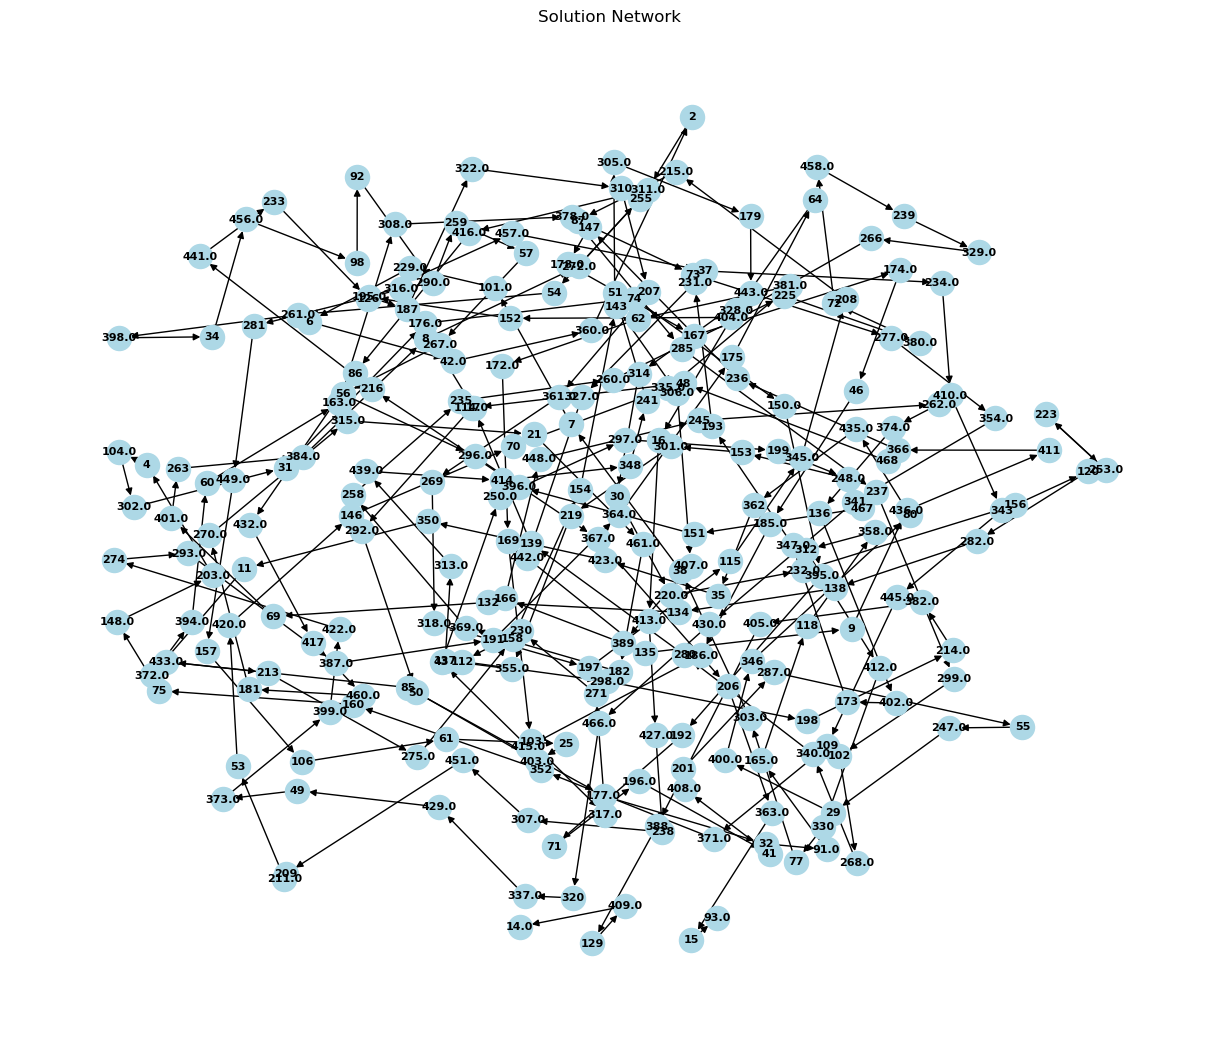

In [10]:
def solution_network(edges):
    G = nx.DiGraph() 

    # Add edges
    for e in edges:
        G.add_edge(e[0], e[1])

    # Draw the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.208, seed=42) 
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='black', 
            node_size=300, font_size=8, font_weight='bold', arrows=True)

    
    plt.title("Solution Network")
    plt.show()

    return G

solution_network(solution_edges)